In [1]:
!pip install sklearn

    100% |████████████████████████████████| 8.0MB 2.5MB/s ta 0:00:011 1% |▍                               | 92kB 648kB/s eta 0:00:13
  Stored in directory: /Users/unnat/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os

In [5]:
base_dir = 'base_dir'
# os.mkdir(base_dir)

In [45]:
#create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [8]:
import pandas as pd

In [9]:
df_data = pd.read_csv('HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [13]:
#this will tell us how many images are associated with each lesion_id

df = df_data.groupby('lesion_id').count()

In [15]:
df.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [16]:
#now we filter out lesion_id's that have only one image associated with 
#it

df = df[df['image_id']==1]

df.reset_index(inplace=True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [21]:
# here we identify lesion_id's that have duplicate images and those
# that have only one image

unique_list = list(df['lesion_id'])
def identify_duplicates(x):
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
## create a new column that is a copy of the lesion_id column

df_data['duplicates'] = df_data['lesion_id']
#apply the function to this new column
df_data['duplicates']= df_data['duplicates'].apply(identify_duplicates)

In [19]:
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [22]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [23]:
# now we filter out images that don't have duplicates 
df = df_data[df_data['duplicates'] == 'no_duplicates']
df.shape

(5514, 8)

In [ ]:
## Now we create a val set using df because we are sure that none of 
## these images
# have augmented duplicates in train set

y = df['dx']
_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)
df_val.shape

In [25]:
df_val['dx'].value_counts()


nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [27]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
# create a list of all the lesion_id's in the val set
val_list = list(df_val['image_id'])



def identify_val_rows(x):
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'
    
    
# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']

# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)


# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [28]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [29]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [30]:
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train


In [31]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [37]:
folder_1 = os.listdir('skin_cancer/train')

In [39]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])




In [46]:
for image in train_list:
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    if fname in folder_1:
        src = os.path.join('skin_cancer/train',fname)
        dst = os.path.join(train_dir,label,fname)
        shutil.copyfile(src,dst)
        

In [48]:
for image in val_list:
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    if fname in folder_1:
        src = os.path.join('skin_cancer/train',fname)
        dst = os.path.join(val_dir,label,fname)
        shutil.copyfile(src,dst)
        

In [47]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [49]:
#check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [112]:
5954+1074+1024+484+301+131+109
751+39+75+30+26+11+6

938

In [1]:
import fastai
from fastai.vision import *

In [2]:
tr = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
data = ImageDataBunch.from_folder(path=base_dir,ds_tfms=tr,size=120).normalize(imagenet_stats)

In [7]:
data.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

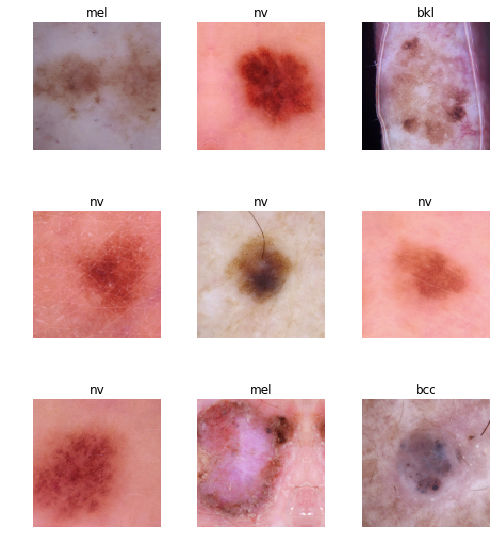

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.train_ds[0][0].shape

torch.Size([3, 120, 120])

In [60]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], 7, 9077, 938)

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
# learn = load_learner("skin_cancer/")

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.174705,0.469586,0.845416,21:16
1,0.821826,0.395174,0.873134,21:20
2,0.707783,0.380872,0.873134,20:05
3,0.659793,0.367133,0.874200,19:58


In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


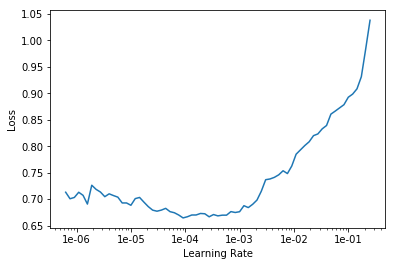

In [17]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.541481,0.287667,0.907249,27:27
1,0.504322,0.282001,0.908316,28:52


In [21]:
learn.save('stage-2')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

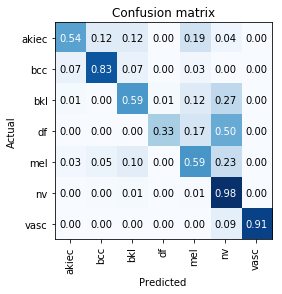

In [23]:
interp.plot_confusion_matrix(normalize=True)

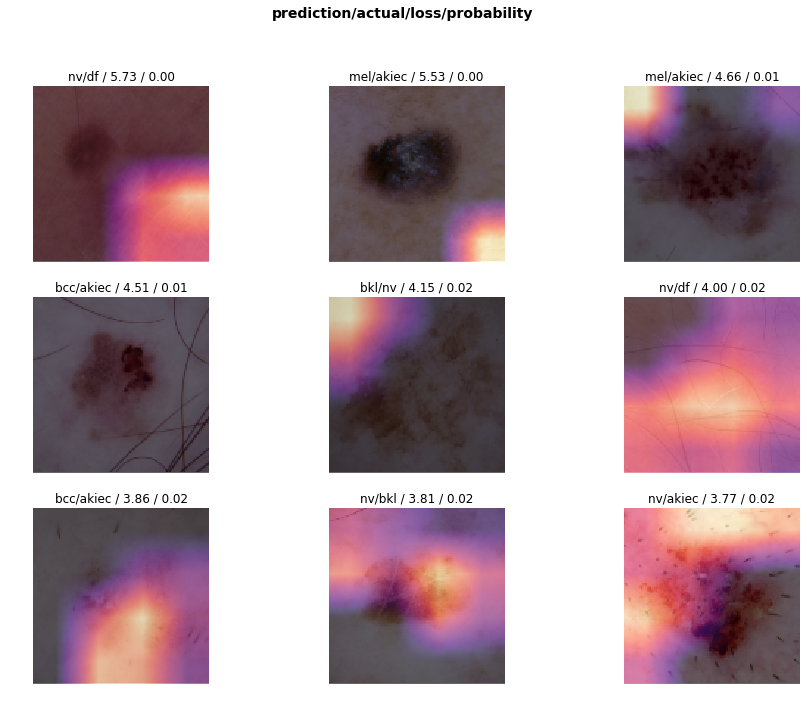

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

In [25]:
# learn.export()

In [93]:
import matplotlib.image as mpimg
import cv2
img = mpimg.imread("base_dir/valid/bcc/ISIC_0030594.jpg")
thumbnail = cv2.resize(img, (120, 120), interpolation = cv2.INTER_AREA)

In [94]:
t = pil2tensor(thumbnail,dtype=np.float32)
t= t.permute(0,2,1)
im = Image(t)
# learn = load_learner("skin_cancer/")

In [106]:
out = learn.predict(im)

In [108]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
full_classes = ["""Actinic keratoses and intraepithelial carcinoma / Bowen's disease""","""Basal cell carcinoma """,
"""Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses""",
"Dermatofibroma","Melanoma","Melanocytic Nevi","Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)"]
dict_ = {val:key for key,val in zip(full_classes,classes)}
[dict_[i[0]] for i in sorted(zip(learn.data.classes, map(float, out[1])),key=lambda p: p[1],reverse=True) if i[1] == 1.0]


['Basal cell carcinoma ',
 'Melanoma',
 'Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)']

In [97]:
import re
re.findall('(.*?);',str(out[0])+';')
# re.findall('(.*?);','re')


['bcc', 'mel', 'vasc']

In [98]:
import numpy as np 
np.argmax(out[0]),out[0].obj[-1]

(0, 'vasc')

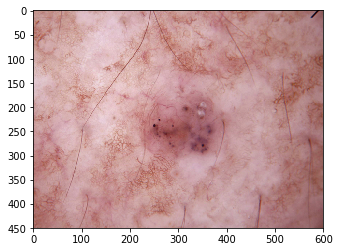

In [99]:
plt.imshow(img)

In [77]:
    def jump(A):
        table = [0]*len(A)
        table[0] = 0
        for i in range(1,len(A)):
            table[i]=i
            if A[i] ==0:
                table[i] = len(A)
                continue
            for j in range(1,A[i]+1):
                if i - j >=0:
                    table[i] = min(table[i],table[i-j]+1)
        print(list(zip(A,table)))
#         print(table)
        print(table[-1])
        return table[-1]

In [71]:
A = [ 9, 0, 0, 22, 0, 0, 39, 11, 3, 0, 0, 24, 1, 0, 50, 23, 3, 44, 0, 23, 2, 8, 20, 35, 0, 40, 34, 26, 36, 0, 35, 19, 20, 18, 11, 43, 19, 21, 40, 0, 14, 0, 14, 0, 0, 25, 35, 24, 49, 15, 13, 3, 0, 10, 31, 25, 27, 37, 27, 43, 44, 27, 8, 43, 0, 0, 33, 25, 19, 47, 0, 29, 5, 2, 12, 8, 7, 0, 16, 36, 0, 6, 17, 35, 36, 21, 0, 9, 1, 0, 43, 29, 39, 15, 18, 0, 34, 26, 48, 0, 34, 35, 7, 10, 0, 0, 15, 5, 12, 26, 0, 37, 30, 33, 27, 34, 9, 37, 22, 0, 0, 24, 30, 0, 0, 38, 23, 25, 0, 30, 39, 24, 31, 0, 6, 19, 25, 0, 28, 15, 8, 0, 48, 0, 35, 41, 0, 24, 1, 41, 31, 0, 35, 21, 15, 26, 15, 27, 4, 0, 8, 4, 0, 0, 2, 42, 18, 0, 28, 18, 49, 34, 5, 10, 41, 48, 26, 14, 45, 44, 9, 0, 49, 50, 24, 0, 0, 0, 23, 0, 17, 0, 47, 31, 0, 42, 0, 0, 0, 40, 46, 22, 50, 32, 20, 3, 44, 22, 0, 37, 25, 0, 19, 26, 14, 23, 27, 41, 0, 1, 13, 0, 48, 20, 37, 8, 0, 18, 0, 26, 12, 19, 32, 19, 22, 0, 0, 0, 0, 0, 16, 0, 0, 43, 0, 10, 5, 0, 6, 26, 0, 24, 40, 29, 0, 43, 18, 27, 0, 0, 37, 0, 46, 35, 17, 0, 20, 44, 29, 29, 40, 33, 22, 27, 0, 0, 38, 21, 4, 0, 0, 15, 31, 48, 36, 10, 0, 41, 0, 45, 39, 0, 11, 9, 3, 38, 16, 0, 11, 22, 37, 0, 3, 44, 10, 12, 47, 22, 32, 7, 24, 1, 0, 22, 25, 0, 14, 0, 0, 0, 23, 0, 36, 1, 42, 46, 0, 48, 0, 33, 5, 27, 45, 0, 15, 29, 0, 50, 2, 31, 25, 6, 36, 19, 10, 23, 0, 37, 4, 1, 7, 12, 0, 0, 49 ]
      0  1  2   3  4  5   6 . 7  8 . 9  10 11 12

IndentationError: unexpected indent (<ipython-input-71-bfee6c9028bd>, line 2)

In [78]:
jump(A)

[(9, 0), (0, 355), (0, 355), (22, 1), (0, 355), (0, 355), (39, 1), (11, 1), (3, 2), (0, 355), (0, 355), (24, 1), (1, 2), (0, 355), (50, 1), (23, 1), (3, 2), (44, 1), (0, 355), (23, 1), (2, 2), (8, 2), (20, 2), (35, 1), (0, 355), (40, 1), (34, 1), (26, 2), (36, 1), (0, 355), (35, 1), (19, 2), (20, 2), (18, 2), (11, 2), (43, 1), (19, 2), (21, 2), (40, 1), (0, 355), (14, 2), (0, 355), (14, 2), (0, 355), (0, 355), (25, 2), (35, 2), (24, 2), (49, 1), (15, 2), (13, 2), (3, 2), (0, 355), (10, 2), (31, 2), (25, 2), (27, 2), (37, 2), (27, 2), (43, 2), (44, 2), (27, 2), (8, 3), (43, 2), (0, 355), (0, 355), (33, 2), (25, 2), (19, 3), (47, 2), (0, 355), (29, 2), (5, 3), (2, 3), (12, 3), (8, 3), (7, 3), (0, 355), (16, 3), (36, 2), (0, 355), (6, 3), (17, 3), (35, 2), (36, 2), (21, 3), (0, 355), (9, 3), (1, 4), (0, 355), (43, 2), (29, 3), (39, 3), (15, 3), (18, 3), (0, 355), (34, 3), (26, 3), (48, 3), (0, 355), (34, 3), (35, 3), (7, 4), (10, 4), (0, 355), (0, 355), (15, 4), (5, 5), (12, 4), (26, 3), 

9

The "neocognitron" was introduced by Kunihiko Fukushima in 1980. It was inspired by the above-mentioned work of Hubel and Wiesel. The neocognitron introduced the two basic types of layers in CNNs: convolutional layers, and downsampling layers. A convolutional layer contains units whose receptive fields cover a patch of the previous layer. The weight vector (the set of adaptive parameters) of such a unit is often called a filter. Units can share filters. Downsampling layers contain units whose receptive fields cover patches of previous convolutional layers. Such a unit typically computes the average of the activations of the units in its patch. This downsampling helps to correctly classify objects in visual scenes even when the objects are shifted.

In a variant of the neocognitron called the cresceptron, instead of using Fukushima's spatial averaging, J. Weng et al. introduced a method called max-pooling where a downsampling unit computes the maximum of the activations of the units in its patch. Max-pooling is often used in modern CNNs.

Several supervised and unsupervised learning algorithms have been proposed over the decades to train the weights of a neocognitron. Today, however, the CNN architecture is usually trained through backpropagation.

The neocognitron is the first CNN which requires units located at multiple network positions to have shared weights. Neocognitrons were adapted in 1988 to analyze time-varying signals.



LeNet-5, a pioneering 7-level convolutional network by LeCun et al. in 1998,that classifies digits, was applied by several banks to recognize hand-written numbers on checks (British English: cheques) digitized in 32x32 pixel images. The ability to process higher resolution images requires larger and more layers of convolutional neural networks, so this technique is constrained by the availability of computing resources.